<a href="https://colab.research.google.com/github/excaangga/CAD-Thorax/blob/main/CAD_thorax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this is a program to assist/replace experts in diagnosing a thorax rontgen result, whether it is Covid-19, Normal, or Pneumonia

! pip install -q kaggle
! echo '{"username":"excaangga", "key":"2418f7e1704119c2519b41cefe02d5f7"}' > kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir datasets
! kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia
! unzip chest-xray-covid19-pneumonia -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/Data/train/COVID19/COVID19(228).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(229).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(23).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(230).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(231).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(232).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(233).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(234).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(235).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(236).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(237).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(238).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(239).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(24).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(240).jpg  
  inflating: datasets/Data/train/COVID19/COVID19(24

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout,  Flatten, Dense,MaxPool2D
 #for explainable
from skimage.segmentation import mark_boundaries
! pip install lime
import lime
from lime import lime_image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 7.6 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=bcefaafff6b5dd696be049a7a893b3b408dd946ff2366b1c94da51230d073b3c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
test_path = "datasets/Data/test"
train_path = "datasets/Data/train"

Text(0.5, 0.98, 'PNEUMONIA X-ray')

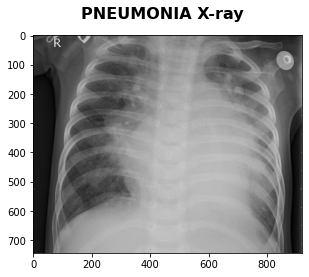

In [ ]:
pneumonia_sample = imread(train_path+"/PNEUMONIA"+"/PNEUMONIA(3140).jpg")
plt.imshow(pneumonia_sample)
plt.suptitle('PNEUMONIA X-ray', fontsize=16, weight='bold')

In [ ]:
temp = Image.open(train_path+"/PNEUMONIA"+"/PNEUMONIA(3140).jpg")
temp.size

(920, 744)

In [ ]:
import fnmatch

print(len(fnmatch.filter(os.listdir(train_path+"/PNEUMONIA"), '*.jpg')))
print(len(fnmatch.filter(os.listdir(train_path+"/COVID19"), '*.jpg')))
print(len(fnmatch.filter(os.listdir(train_path+"/NORMAL"), '*.jpg')))

3418
460
1266


In [ ]:
# IMAGE PREPROCESSING
train_datagen = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=True)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224,224),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

# CNN
im_size = (224,224,3)

model = keras.Sequential([keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=im_size),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Conv2D(128, (3,3), activation='relu'),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Conv2D(256, (3,3), activation='relu'),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Dropout(0.3),
                          keras.layers.Flatten(),
                          keras.layers.Dense(256, activation='relu'),
                          keras.layers.Dense(3, activation='softmax')
                          ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


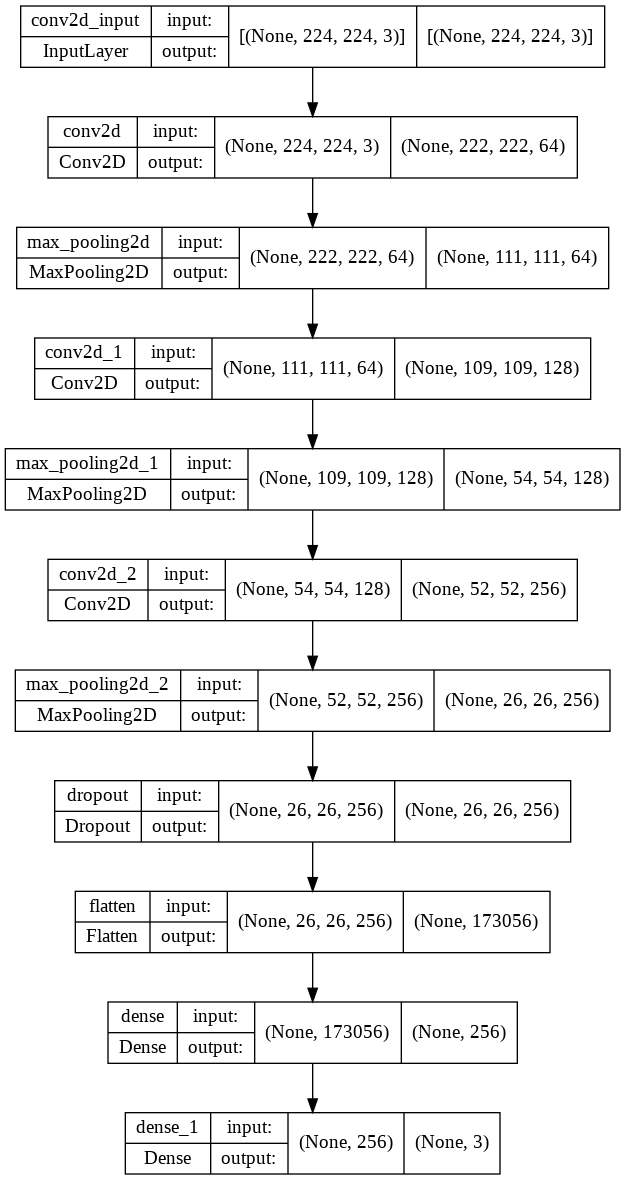

In [ ]:
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=5, steps_per_epoch=128)

Epoch 1/5
128/128 [==============================] - 1198s 9s/step - loss: 0.6274 - acc: 0.8191 - val_loss: 0.2182 - val_acc: 0.9231
Epoch 2/5
128/128 [==============================] - 1181s 9s/step - loss: 0.2270 - acc: 0.9136 - val_loss: 0.2487 - val_acc: 0.9115
Epoch 3/5
128/128 [==============================] - 1169s 9s/step - loss: 0.1852 - acc: 0.9374 - val_loss: 0.1792 - val_acc: 0.9348
Epoch 4/5
128/128 [==============================] - 1175s 9s/step - loss: 0.1703 - acc: 0.9376 - val_loss: 0.2425 - val_acc: 0.9193
Epoch 5/5
128/128 [==============================] - 1185s 9s/step - loss: 0.1448 - acc: 0.9453 - val_loss: 0.1479 - val_acc: 0.9472


In [ ]:
# model.save('/content/thorax_model_final.h5')
# model = tf.keras.models.load_model('/content/thorax_model_final.h5')

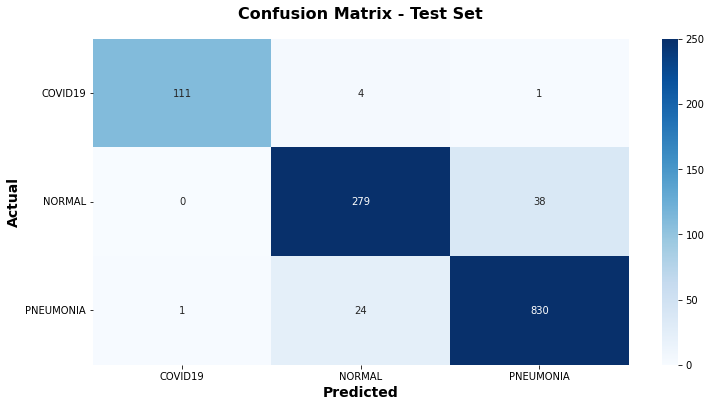

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


classes = ["COVID19", "NORMAL", "PNEUMONIA"]

y_pred = model.predict(test_generator)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_generator.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

prediction:  COVID19


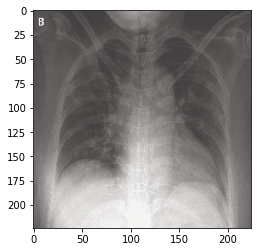

In [ ]:
class_dict = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

file_path =  'datasets/Data/test/COVID19/COVID19(538).jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

prediction:  PNEUMONIA


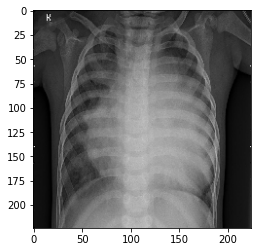

In [ ]:
file_path =  'datasets/Data/test/PNEUMONIA/PNEUMONIA(3420).jpg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)
probs = model.predict(test_image)
pred_class = np.argmax(probs)

pred_class = class_dict[pred_class]

print('prediction: ',pred_class)

In [ ]:
def find_true_class(file_path):
    true_class = None
    if 'COVID19' in file_path:
        true_class = 'COVID19'
    elif 'PNEUMONIA' in file_path:
        true_class = 'PNEUMONIA'
    elif 'NORMAL' in file_path:
        true_class = 'NORMAL'
    return true_class

In [ ]:
def visualize(file_path,ax,text_loc):
    test_image = cv2.imread(file_path)
    test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
    test_image = np.expand_dims(test_image,axis=0)
    probs = model.predict(test_image)
    pred_class = np.argmax(probs)
    pred_class = class_dict[pred_class]

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(test_image[0], model.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)


    ax.imshow(mark_boundaries(temp, mask))
    fig.text(text_loc, 0.9, "Predicted Class: " + pred_class , fontsize=13)
    true_class = find_true_class(file_path)
    if true_class is not None:
        fig.text(text_loc, 0.86, "Actual Class: " + true_class , fontsize=13)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

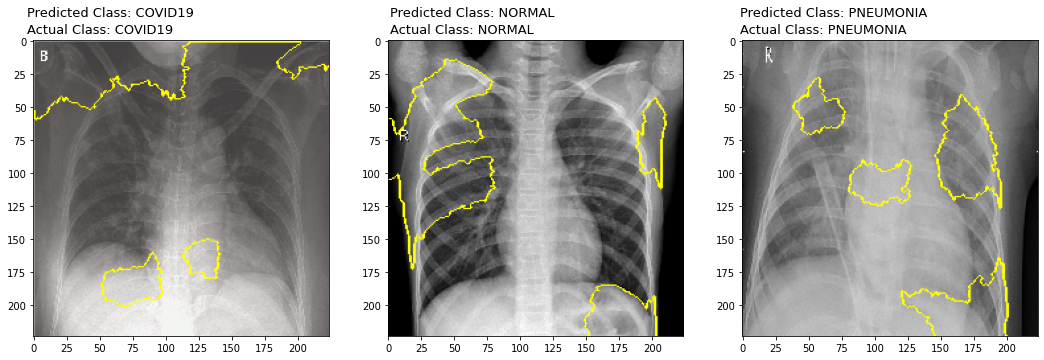

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
visualize('datasets/Data/test/COVID19/COVID19(538).jpg',ax[0],0.12)
visualize('datasets/Data/test/NORMAL/NORMAL(1540).jpg',ax[1],0.4)
visualize('datasets/Data/test/PNEUMONIA/PNEUMONIA(3431).jpg',ax[2],0.67)

**TAMBAH PERFORMANCE METRIC UNTUK CLASSIFICATION MODEL**

In [ ]:
# F1 SCORE
from sklearn.metrics import f1_score

# class_dict = {0:'COVID19',
#               1:'NORMAL',
#               2:'PNEUMONIA'}

f1_score(y_true, predictions, average=None)

array([0.97368421, 0.89423077, 0.96287703])

In [ ]:
# AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score

AUC = roc_auc_score(y_true, y_pred, multi_class='ovr') # Above 0.5 is good
AUC

0.9901618329137393

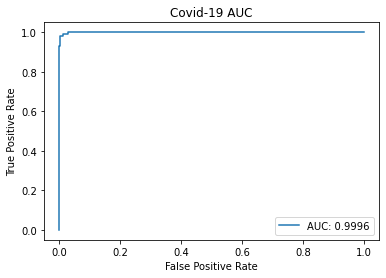

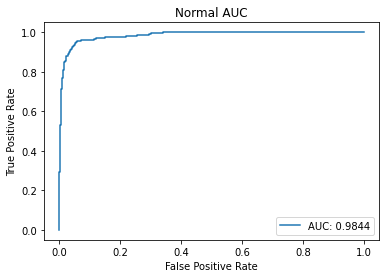

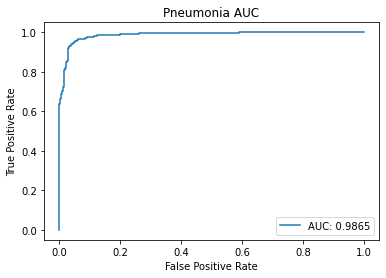

In [ ]:
# AUC graph
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

for i in range(3):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred[:, i], pos_label=i)
  plt.plot(fpr, tpr, label='AUC: {0:.4f}'.format(np.trapz(tpr, fpr)))
  if i == 0:
    plt.title('Covid-19 AUC')
  elif i == 1:
    plt.title('Normal AUC')
  else:
    plt.title('Pneumonia AUC')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='best')
  plt.show()